# Hugging Face API Image Generation and Filtering

## Introduction

In this blog post, we will explore how to use the Hugging Face API, Stable Diffusion, and Face2Paint to generate and filter images. You can run this post in Google Colab using this link:

<a href="https://colab.research.google.com/github/arminnorouzi/image_generator/blob/main/image_generator_hugging_face.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Let's get started with some introduction on Hugging Face and models we are going to use:

- [Hugging Face](https://huggingface.co/) is a popular platform that provides a wide range of pre-trained models and APIs for natural language processing and computer vision tasks.

- [StabilityAI Stable Diffusion v2](https://github.com/stabilityai/stable-diffusion-2) is a powerful model for image generation. It is based on the stable-diffusion-2-base, which is a pre-trained model checkpoint with a base size of 512. The stable-diffusion-2 model was trained for 150,000 steps using a v-objective on a specific dataset. It was then further trained for an additional 140,000 steps on 768x768 images, allowing it to generate high-quality images.


- [Face2Paint](https://github.com/chuanli11/Face2Paint) is a project that aims to generate artistic images from input photos, allowing users to transform a portrait photo into a painting-like image.

## Installation

To run this notebook, we need to install the necessary libraries and dependencies. Execute the following code to install them:


In [1]:
import requests
import io
from PIL import Image
from io import BytesIO
from google.colab import files
import torch
import ipywidgets as widgets
import IPython.display as display

## Hugging Face API

The Hugging Face API allows us to interact with pre-trained models hosted on the Hugging Face model hub. To use the API, you need an API token, which authenticates your requests.

### Obtaining an API Token

To obtain an API token, follow these steps:

1. Go to the Hugging Face website: [https://huggingface.co/](https://huggingface.co/).
2. Sign up or log in to your Hugging Face account.
3. Navigate to the **Dashboard** section.
4. Click on your username in the top-right corner and select **Account settings**.
5. In the account settings, go to the **API token** tab.
6. Click on **Create New API Token**.
7. Copy the generated API token.

### Using the Hugging Face API Token

Once you have obtained your API token, you can use it to authenticate your requests to the Hugging Face API. Update the `API_TOKEN` variable below with your token:


In [2]:
API_TOKEN = "YOUR_API_TOKEN"

Now let's add `API_URL` and and `headers`. The `headers` dictionary contains the HTTP headers for the API request. The `Authorization` header is set using the API token we obtained earlier. This header is necessary for authentication purposes when making requests to the Hugging Face API.

In [3]:
API_URL = "https://api-inference.huggingface.co/models/stabilityai/stable-diffusion-2"
headers = {"Authorization": f"Bearer {API_TOKEN}"}

## Filtering API

If a GPU is available, the device will be set to `"cuda"`, which enables faster computation using GPU acceleration. Otherwise, it will be set to `"cpu"`, indicating that computations will be performed on the CPU.

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

Next, we load the `AnimeGAN2` generator model using the `torch.hub.load()` function from the `bryandlee/animegan2-pytorch:main` repository:

In [5]:
model = torch.hub.load("bryandlee/animegan2-pytorch:main", "generator", device=device).eval()

/usr/local/lib/python3.10/dist-packages/torch/hub.py:286: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/bryandlee/animegan2-pytorch/zipball/main" to /root/.cache/torch/hub/main.zip
Downloading: "https://github.com/bryandlee/animegan2-pytorch/raw/main/weights/face_paint_512_v2.pt" to /root/.cache/torch/hub/checkpoints/face_paint_512_v2.pt
100%|██████████| 8.20M/8.20M [00:00<00:00, 65.5MB/s]


The `model` variable holds the generator model that is used to generate anime-style images. By calling `torch.hub.load()`, we load the pre-trained generator model from the specified repository. The `device=device` argument ensures that the model is loaded onto the correct device (either CPU or GPU).

We also load the Face2Paint model from the same repository:

In [6]:
face2paint = torch.hub.load("bryandlee/animegan2-pytorch:main", "face2paint", device=device)

Using cache found in /root/.cache/torch/hub/bryandlee_animegan2-pytorch_main


The `face2paint` variable contains the Face2Paint model, which is responsible for transforming a portrait photo into a painting-like image. Similar to the generator model, we load the Face2Paint model using `torch.hub.load()` and specify the device to use.

We define the `image_format` variable to specify the format of the generated images. By default, it is set to `"png"`. If you prefer to use a different image format such as `JPEG`, you can change it by modifying the following line:

In [7]:
image_format = "png" 

Simply replace `"png"` with `"jpeg"` or the desired image format.

Now, we have configured the necessary components for image generation and filtering.

## Required functions 
We can simplify our query by creating some functions.

Let's start with `query(payload)`. This function sends a POST request to the Hugging Face API with the provided payload. It returns the response content.

In [8]:
def query(payload):
    """
    Sends a POST request to the Hugging Face API with the provided payload.

    Args:
        payload (dict): The payload containing the request inputs and options.

    Returns:
        bytes: The content of the response.
    """
    response = requests.post(API_URL, headers=headers, json=payload)
    return response.content

`text_to_image(prompt, image_name)` function converts a text prompt into an image by making a query to the Hugging Face API. It saves the generated image and returns the image as a `PIL Image object`.

In [9]:
def text_to_image(prompt, image_name):
    """
    Converts a text prompt into an image using the Hugging Face API.

    Args:
        prompt (str): The text prompt to generate an image from.
        image_name (str): The desired name for the generated image.

    Returns:
        PIL.Image.Image: The generated image as a PIL Image object.
    """
    image_bytes = query({"inputs" : prompt, 
                         "options" : {"use_cache" : False,
                                      "wait_for_model" : True}})
    image_raw = Image.open(io.BytesIO(image_bytes)).convert("RGB")
    image_raw.save(image_name + ".png")
    return image_raw

Let's put everything together in the `run_promp(prompt, image_name)` function. This function combines the text-to-image generation and the image filtering steps. It calls the `text_to_image` function to generate an image from the provided prompt. Then, it calls the `filter_run function` to apply the Face2Paint filter to the generated image. It returns both the original and filtered images as `PIL Image` objects.

In [10]:
def filter_run(image, image_name):
    """
    Applies the Face2Paint filter to the input image.

    Args:
        image (PIL.Image.Image): The input image to apply the filter to.
        image_name (str): The desired name for the filtered image.

    Returns:
        PIL.Image.Image: The filtered image as a PIL Image object.
    """
    im_in = image
    im_out = face2paint(model, im_in, side_by_side=False)
    im_out.save(image_name + "_filtered" + ".png")
    return im_out

`filter_run(image, image_name)` function applies the Face2Paint filter to the input `image`. It takes the image as input, applies the filter using the `face2paint` model, and saves the filtered image. It returns the filtered image as a `PIL Image` object.

In [11]:
def run_promp(prompt, image_name):
    """
    Generates and filters images based on the provided prompt.

    Args:
        prompt (str): The text prompt to generate an image from.
        image_name (str): The desired name for the generated and filtered images.

    Returns:
        Tuple[PIL.Image.Image, PIL.Image.Image]: A tuple containing the generated and filtered images as PIL Image objects.
    """
  
    image_raw = text_to_image(prompt, image_name)
    image_filter = filter_run(image_raw, image_name)

    return image_raw, image_filter

## Running query and saving images

Now we can write a function to get a query, the name of the file we want and a flag to determine whether to download images.

In [12]:
def generate_and_save_image(prompt, file_name, save_image = True):
    """
    Generates and displays an image based on the provided prompt and saves it to the disk.

    Args:
        prompt (str): The text prompt to generate an image from.
        file_name (str): The desired name for the generated and filtered images.
        save_image (bool, optional): Whether to save the images to the disk. Defaults to True.

    Returns:
        None
    """
    image_raw, image_filter = run_promp(prompt, file_name)
    print("\n #### Raw image #### \n")
    image_raw.show()
    print("\n #### Filtered image #### \n")
    image_filter.show()

    if save_image:
      files.download(file_name+ ".png") 
      files.download(file_name + "_filtered" + ".png") 

The `generate_and_save_image` function takes three arguments: `prompt`, which is the text prompt to generate an image from; `file_name`, which is the desired name for the generated and filtered images; and `save_image`, which is a boolean flag indicating whether to save the images to the disk (default is set to True).

Inside the function, it calls the `run_prompt` function to generate and obtain the raw and filtered images based on the provided prompt and file name. Then, it displays the raw and filtered images using the `show()` method from the PIL Image object.

If the `save_image` flag is set to True, it uses the `files.download` function from Google Colab to download and save the generated image and filtered image with the specified file names.

Let's run some examples:

1. Running unicorn: Let's set the prompt variable to `"running unicorn"`, which will be used as the text prompt to generate the image. The `file_name` variable is set to "unicorn", which specifies the desired name for the generated and filtered images.


 #### Raw image #### 



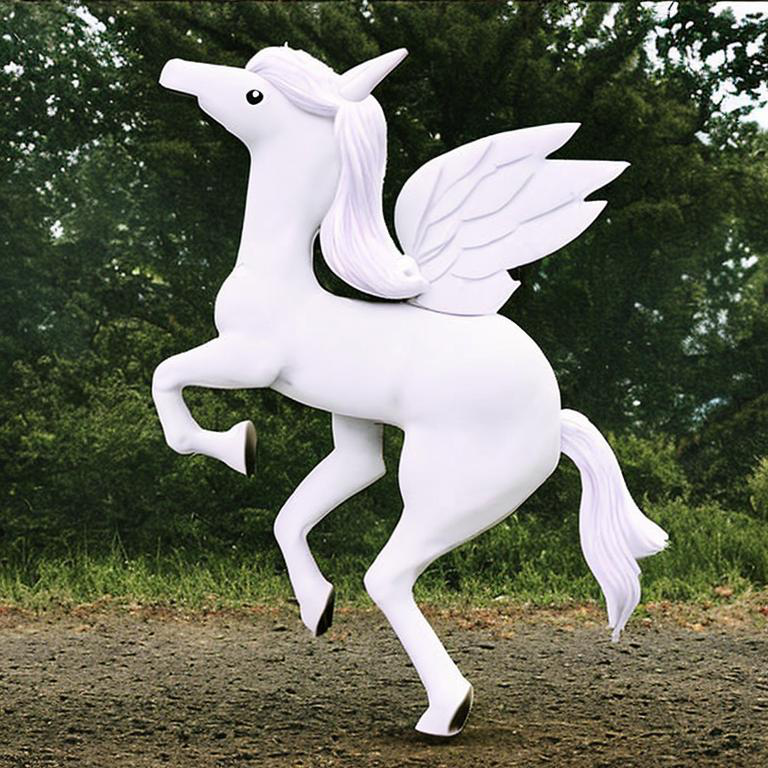


 #### Filtered image #### 



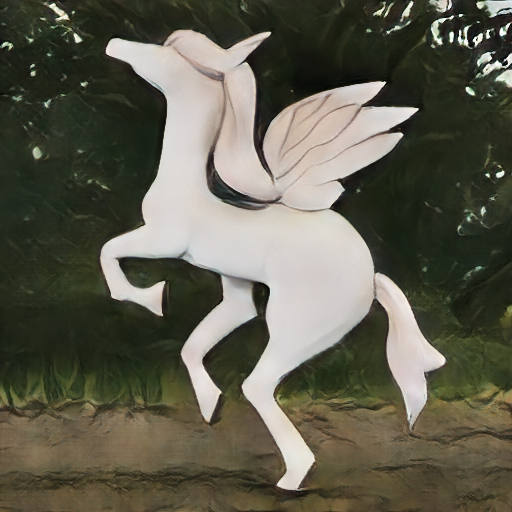

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [13]:
prompt = "running unicorn"
file_name = "unicorn"

generate_and_save_image(prompt, file_name, save_image=True)



2. Sunset over the ocean


 #### Raw image #### 



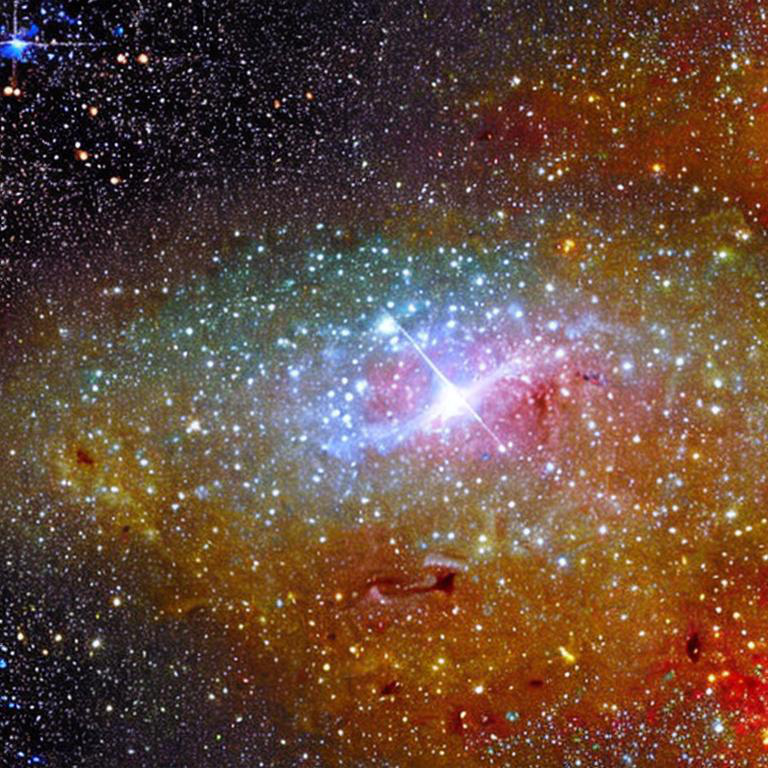


 #### Filtered image #### 



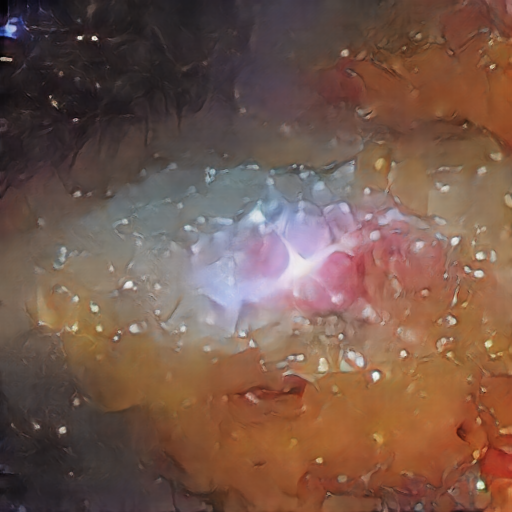

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [14]:
prompt = "galaxy in outer space"
file_name = "galaxy"

generate_and_save_image(prompt, file_name, save_image=True)


3. beautiful mountain landscape


 #### Raw image #### 



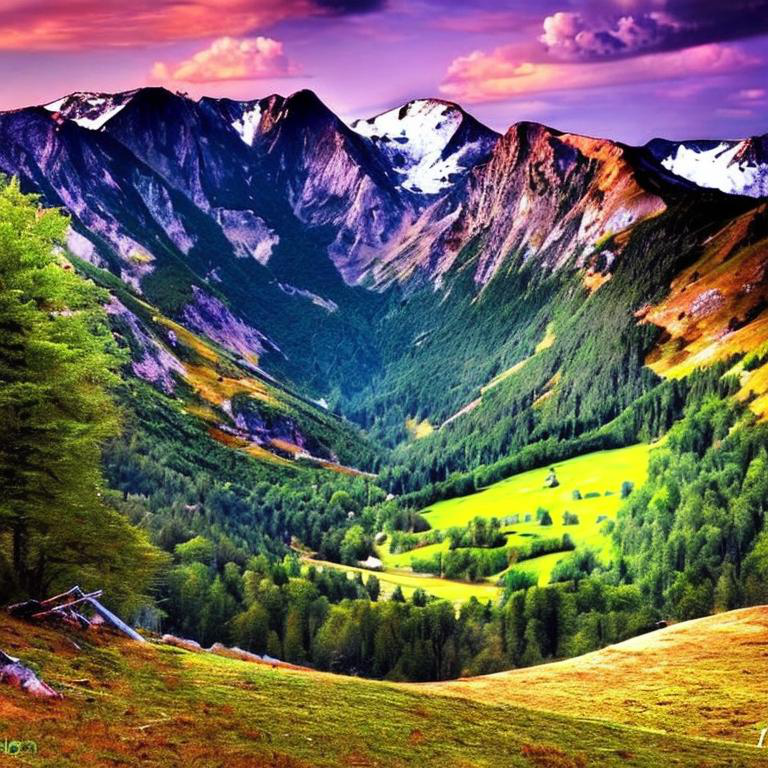


 #### Filtered image #### 



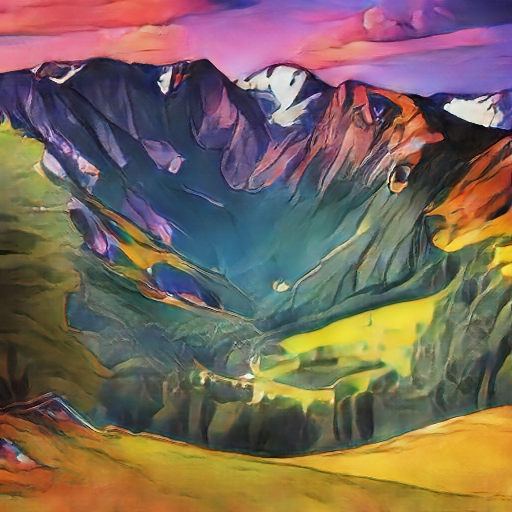

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [15]:
prompt = "beautiful mountain landscape"
file_name = "mountain"

generate_and_save_image(prompt, file_name, save_image=True)

4. Flying elephants in the sky


 #### Raw image #### 



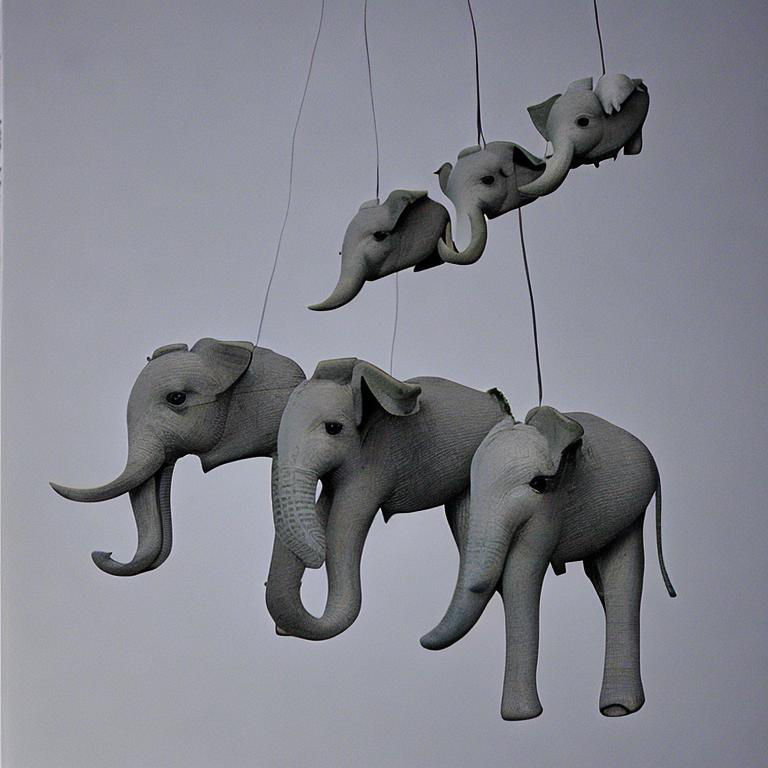


 #### Filtered image #### 



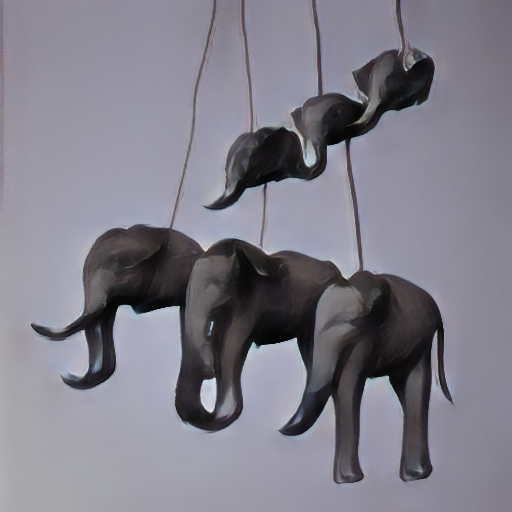

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [16]:
prompt = "flying elephants in the sky"
file_name = "elephants"

generate_and_save_image(prompt, file_name, save_image=True)


5. mermaids riding bicycles underwater


 #### Raw image #### 



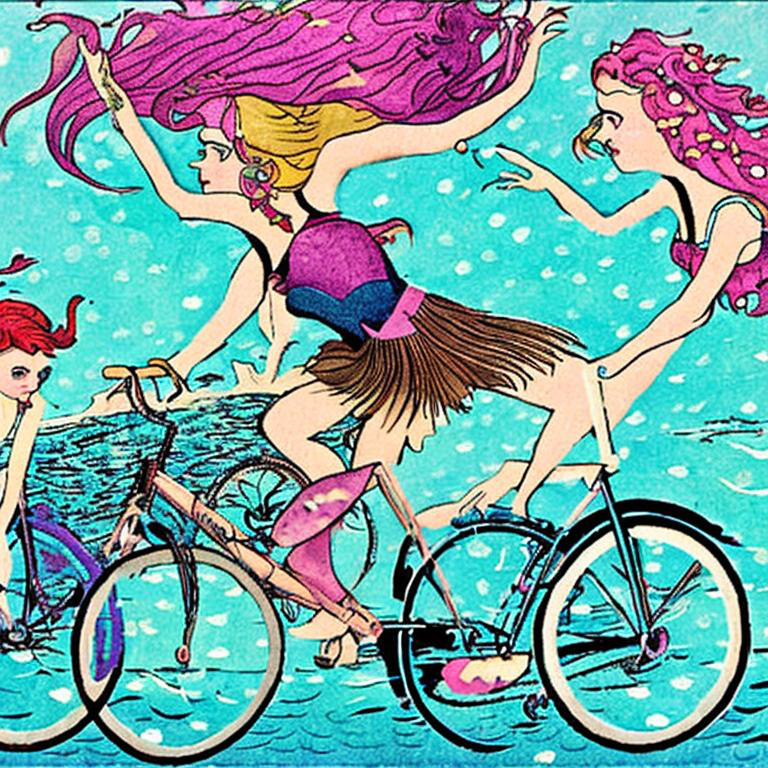


 #### Filtered image #### 



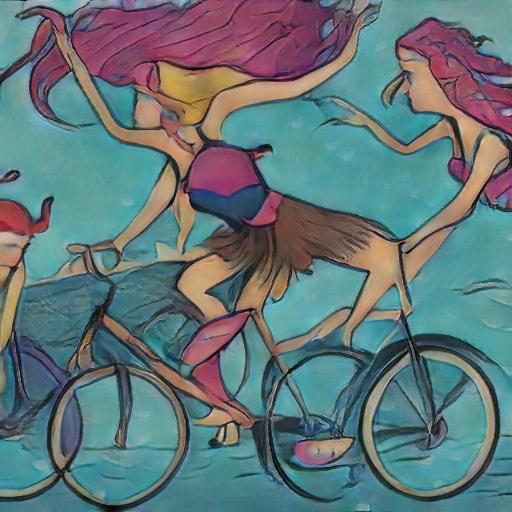

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [17]:
prompt = "mermaids riding bicycles underwater"
file_name = "mermaids"

generate_and_save_image(prompt, file_name, save_image=True)


## Conclusion

In this post, we have explored the usage of the Hugging Face API for image generation and filtering. By leveraging the power of the Stable Diffusion v2 model from Hugging Face and the AnimeGAN2-PyTorch model, we were able to generate visually appealing and creative images based on text prompts.

Happy generating as unrealistic images as you want and filtering then to painting!

